# Matrix Differential Equations

In this section, we will work on finding a purely numerical solution to the time independent Schrödinger Equation (SE). 

$$ -\frac{\hbar^2}{2m}\nabla^2 \psi(x) + V(x)\psi(x) = E\psi(x)$$

which in one dimension looks like:

$$ -\frac{\hbar^2}{2m}\frac{d^2}{d x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$$

Our method for solving this will be to write this as a **matrix** equation and then finding the (energy) eigenvalues and (wave) eigenfunctions.

Our choice of potential here will be infinite square well, but this can be modified to consider a range of other quantum systems.

## Method

We will use a [finite differences](https://uclnatsci.github.io/2022/NSCI0011/fdiff/intro.html) method to calculate the derivatives, we will use a simple stencil for this (although could include more terms later).  In order to write this system in matrix form, we will turn the function $\psi(x)$ into a vector (which is a list in Python) and the operator of the differential equation into a matrix - this produces a matrix eigenequation, which we can diagonalize to get our answers.

### Discretization

The process of discretization is simply turning our continuous space $x$, into a discrete number of steps, $N$, and our function $\psi(x)$ into an array of size $N$. We thus have $N$ values $x_i$, which have a stepsize $h = \Delta x = x_{i+1} - x_i$. Our choice of the *size* of our space, $N$, turns out to be important. Too large a number will slow down our computation and require too much computer memory, too small a number and the answers we compute will not be sufficiently accurate. A common practice is to start with a small number $N$ and then increase it until the accuracy is acceptable. The actual value you obtain in the end will depend on the problem you are studying. 

### Forward and Backward first order differential

We first need to develop how we will take the derivative of our function. Going back to our introduction to calculus, we remember that the derivative was defined as:

$$\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x)}{\Delta x} \approx \frac{f(x+h) - f(x)}{h} + \mathrm{O}(h)$$

When we take a *finite difference*, we simply not take the limit all the way down to 0, but stop at $\Delta x = h$. Note that for this equation we evaluate the point just *after* $x$, which we call the *forward difference*. If you actually let $\Delta x \rightarrow 0$, then this does not matter, but if you do a finite difference, you can also do:

$$\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x) - f(x-\Delta x)}{\Delta x} \approx \frac{f(x) - f(x-h)}{h} + \mathrm{O}(h)$$

which is known as the *backward difference*. 

You can also compute a *central difference*, but cannot use steps of $\frac{1}{2}\Delta x$, since that does not exist in our space. The central difference is then a combination of the previous two:

$$\frac{d}{dx} f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x-\Delta x)}{2\Delta x}\approx \frac{f(x+h) - f(x-h)}{2h} + \mathrm{O}(h^2)$$

As you will have discussed in the finite differences section, the central difference method can have an error quite a bit lower than the than the first two methods.

Note that for any of these approximations to a derivative, we have a problem at the edges of our space. Either on one end or the other, there is no $x-\Delta x$ or $x+\Delta x$, but here we are just not going to worry about this detail.

#### Matrix representation

We now want to turn the equation into a matrix equation for us to evaluate. If you just want to take the derivative of a function stored in an array, then this is not needed, you can run a loop and evaluate the equation for each $x_i$, but if you want to solve a differential equation, we need the matrix.

We introduce the vectors $f(x) = [f_0,f_1,f_2,...,f_{N-1}]$ and for the derivative $f'(x) = [f'_0,f'_1,f'_2...,f'_{N-1}]$. 

The forward difference derivative can then be written as:

$$f'_i = (f_{i+1} - f_i)/h $$

And the matrix equation for the forward difference derivative is just:

$$\begin{pmatrix}f'_0 \\ f'_1 \\\vdots \\ f'_{N-1}\end{pmatrix} = \frac{1}{h}
\begin{pmatrix} -1 & 1 & 0 & & \\ 0 & -1 & 1 & & \\ & & \ddots & \ddots \\
& & & -1 & \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\\vdots \\ f_{N-1}\end{pmatrix}$$

We note that the last entry in the matrix will not be correct because there is no element for $N$. We can fix this up by taking the *backward* derivative at the last point.

We can show this in action by taking the derivative of $\sin(x)$ and plotting the result.

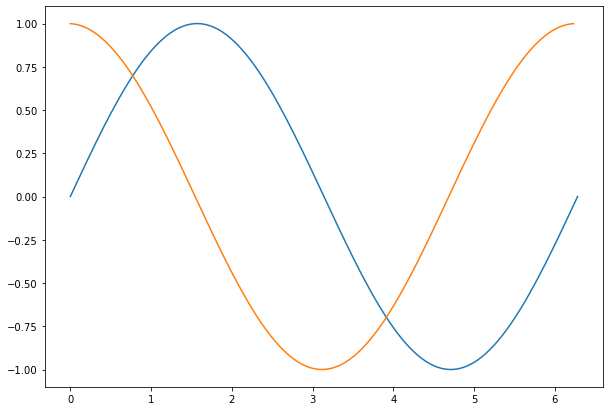

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Define the number of points in our space, N
N = 128
a = 2*np.pi

# Define the x space from 0 to a with N-1 divisions.
x = np.linspace(0,2*np.pi,N)

# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

# Compute the function, y = sin(x). With numpy this is easy:
y = np.sin(x)

# We compute the matrix using the np.diag(np.ones(N),0) which creates a 
# diagonal matrix of 1 of NxN size. Multiply by -1 to get -1 diagonal array.
# You get an +1 off-diagonal array of ones, with np.diag(np.ones(N-1),1)
# Note that you need N-1 for an NxN array, since the off diagonal is one smaller.
# Add the two together and normalize by 1/h
Md = 1./h*(np.diag( -1.*np.ones(N),0) + np.diag(np.ones(N-1),1))

# Compute the derivative of y into yp by matrix multiplication:
yp = Md.dot(y)

# Plot the results.
plt.figure(figsize=(10,7))
plt.plot(x,y)
plt.plot(x[:-1],yp[:-1]) # Don't plot last value, which is invalid
plt.show()

## Second order Differential
We can now extend this method to the second order differential. If we take the backward differential of the result of a forward differential, we get:

$$\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f'(x)-f'(x-\Delta x)}{\Delta x} =  \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - f(x) - (f(x) - f(x-\Delta x))}{\Delta x^2} \\
\frac{d^2}{dx^2}f(x) = \lim_{\Delta x \rightarrow 0} \frac{f(x+\Delta x) - 2f(x) + f(x-\Delta x))}{\Delta x^2} \approx \frac{f(x+h) - 2f(x) + f(x-h))}{h^2}$$

So in the discrete space we can write this as:

$$ f''_i = (f_{i+1} - 2f_i + f_{i-1})/h^2 $$

And finally, as a matrix equation, the second derivative is then:

$$\begin{pmatrix}f''_0 \\ f''_1 \\ f''_2 \\\vdots \\ f''_{N-1}\end{pmatrix} = \frac{1}{h^2}
\begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix}\begin{pmatrix}f_0 \\ f_1 \\ f_2 \\\vdots \\ f_{N-1}\end{pmatrix}$$

Where now we note that at both ends of our array we will get an inaccurate answer unless we do some fixup. The fixup in this case is to use the same elements as the row below (at the start) or the row above (at the end), so we get $f''_0 = f''_1$ and $f''_{N-1} = f''_{N-2}$, which is not great but better than the alternative.

We can now try this matrix to compute the second derivative of our $y(x)$ array.

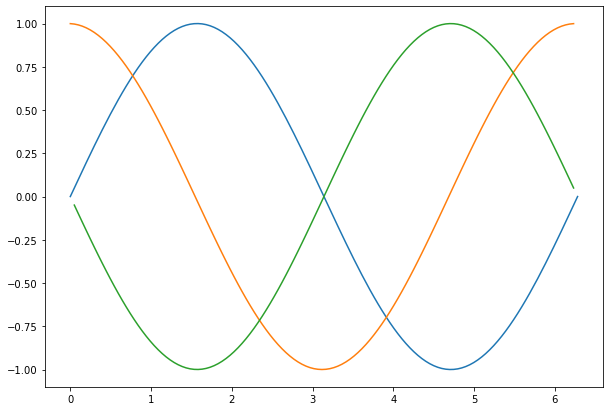

In [2]:
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) + np.diag( -2.*np.ones(N),0) + np.diag(np.ones(N-1),1))
ypp = Mdd.dot(y)
plt.figure(figsize=(10,7))
plt.plot(x,y)
plt.plot(x[:-1],yp[:-1])     # Last value is invalid, don't plot
plt.plot(x[1:-1],ypp[1:-1])  # First and last value is invalid.
plt.show()

## Solving the Schrödinger Equation

We can now setup the Schrodinger Equation as a matrix equation:

$$\hat H = \frac{\hbar^2}{2m}\frac{d^2}{d x^2} + V \\
\hat H \psi(x) = E \psi(x)$$

We now know the matrix for taking the second order derivative. The matrix for the potential is simply the values of the potential on the diagonal of the matrix: $\mathbf{V}_{i=j} = V_i$. 

Writing out the matrix for $\mathbf{H}$ we get:

$$\mathbf{H} = \frac{-\hbar^2}{2 m h^2} \begin{pmatrix} -2 & 1 & 0 & 0 & \\ 1 & -2 & 1 & 0 & \\ 
0& 1 & -2 & 1 &  \\ &  & \ddots & \ddots & \ddots &\\
&  & & 1 & -2 \end{pmatrix} + 
\begin{pmatrix} V_0 & 0 & 0 & & \\ 0 & V_1 & 0 & & \\ 0 & 0 & V_2 & & \\ & & &\ddots & \\ &&&&V_{N-1}\end{pmatrix}$$ 

It is worth looking at the matrix of the Hamiltonian and notice the symmetry: $\mathbf{H}^T = \mathbf{H}$, so the transpose of the matrix is identical to the matrix. Since the matrix is *real* everywhere, the complex conjugate is also the same: $\mathbf{H}^*=\mathbf{H}$. Combining these two statements, we can say that the Hamiltonian is Hermitian: $\mathbf{H}^\dagger = \mathbf{H}$.

### Infinite Square Well
The very simplest system to solve for is the infinite square well, for which $V=0$. We will readily recognize the results as alternating $\cos(x)$ and $\sin(x)$ functions, and the energy levels are:

$$E_i = \frac{n^2\pi^2\hbar^2}{2ma^2}$$

First, we need to discuss a subtlety - the infinite square well from $-a/2$ to $a/2$ has $V=\infty$ *at* these points, but obviously we would get into trouble trying to enter an infinite potential in our model, so we just limit the computational space to just worry about $-a/2+h$ to $a/2-h$, where $h$ is our step size and then use boundary conditions to force the wavefunction to be zero at the space end points. 

We create $x_{full}$ as the full x-axis from $-a/2$ to $a/2$, but take $N+2$ steps, but leave out the first and last point when calculating the wavefunctions. Just before we we want to use the solutions however (e.g. before plotting) we add a zero to the beginning and end of the wavefunctions, so that we get the expected result.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
hbar=1
m=1
N = 512
a = 1.0
x = np.linspace(-a/2.,a/2.,N)

# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)
V = 0.*x
Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 

E,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors

psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]


One additional thing to worry about is We want to verify that these resuls make sense, so we plot the wave functions and compute the norms. Note that the eigenvectors are normalized in such a way that $\sum_n \psi^2_n (x_i) = 1$. 

This does not take into account the step size that we used for discretizing the space and we want to plot the wave functions in such a way that they plot the same independent of our choice of step size, so to do this we need to divide the array of numbers by $\sqrt{\Delta x}$ before plotting.

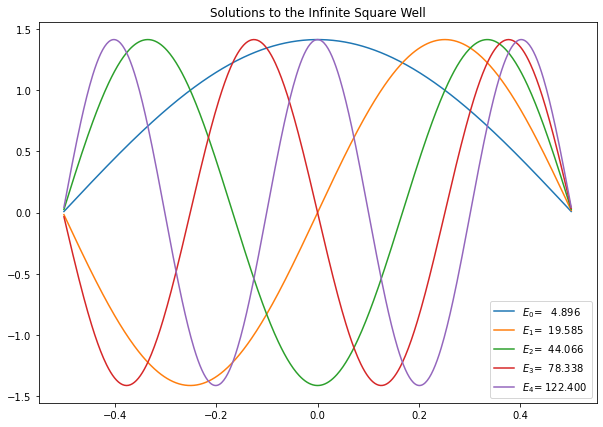

In [4]:
plt.figure(figsize=(10,7))
for i in range(5):
    if psi[i][N-10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
        plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
    else:
        plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
    plt.title("Solutions to the Infinite Square Well")
plt.legend()
# plt.savefig("Infinite_Square_Well_WaveFunctions.pdf") # we could also save these to .pdf if required
plt.show()


We now also want to check that the energy levels do indeed correspond to the known energy levels of this quantum model:

$$E_n = \frac{n^2 \pi^2 \hbar^2}{2 m a^2}$$

In [5]:
for i in range(7):
    n = i+1
    print("E[{}] = {:9.4f}, E_{} ={:9.4f}".format(n,E[i],n, n*n*np.pi**2*hbar*hbar/(2*m*a*a)))

E[1] =    4.8964, E_1 =   4.9348
E[2] =   19.5854, E_2 =  19.7392
E[3] =   44.0664, E_3 =  44.4132
E[4] =   78.3385, E_4 =  78.9568
E[5] =  122.4004, E_5 = 123.3701
E[6] =  176.2505, E_6 = 177.6529
E[7] =  239.8868, E_7 = 241.8053


You can see that as N gets larger the results for the energy levels become more accurate. Values of N as large as $2^{10} = 1024$ or $2^{15} = 20148$ can still give results quickly on a desktop computer.

One final test here shows the accuracy of our calculation in the **orthonormality** of the states:

In [18]:
for j in range(5):
    for i in range(5):
        print("{:16.9e}".format(np.sum(psi[j]*psi[i])),end=" ")
    print()

 1.000000000e+00  5.551115123e-17  3.053113318e-16  1.626303259e-18 -3.794707604e-18 
 5.551115123e-17  1.000000000e+00 -5.551115123e-17 -3.291908846e-17 -1.561251128e-17 
 3.053113318e-16 -5.551115123e-17  1.000000000e+00  1.214306433e-17 -9.107298249e-18 
 1.626303259e-18 -3.291908846e-17  1.214306433e-17  1.000000000e+00  1.110223025e-16 
-3.794707604e-18 -1.561251128e-17 -9.107298249e-18  1.110223025e-16  1.000000000e+00 


## Finite Square Well Bound State

Now we can have a go at solving the Schrödinger equation using different potentials to calculate the bound states for a finite square well. 

There are only a few changes to the infinite square well solution:

1\. The potential is different, in that it has a small area which is not zero but some negative value, here $−𝑉_0$

2\. For our calculation to be approximately correct, we need to make sure that our entire calculation space $−𝑎/2 \leq x \leq 𝑎/2$ is much larger than the size of the well $−𝑏/2 \leq x \leq 𝑏/2$ - this is to ensure that other behvaiour of the wave function is also captured. The factor 50 between $a$ and $b$ here is probably more than needed - but see if adjusting this significantly changes the results much!

3\. We also need a fairly large $𝑁$, the number of steps in our space, so that the resulting wave function is smooth in the area of the well - you may need to be somewhat patient when evaluating the well with these settings! 

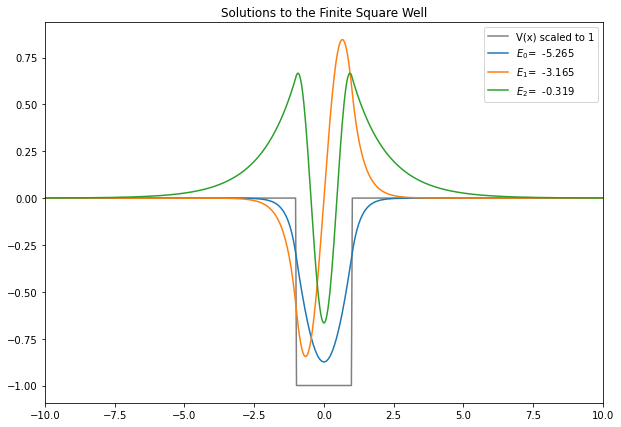

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
hbar=1
m=1
N = 3000
a = 100.0
b = 2.
x = np.linspace(-a/2.,a/2.,N)

# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)
V0 = -6.
V=np.zeros(N)
for i in range(N):
    if x[i]> -b/2. and x[i]< b/2.:
        V[i]= V0

Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 

E,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]

plt.figure(figsize=(10,7))
plt.xlim((-5*b,5*b))
plt.plot(x,V/(-V0),color="Gray",label="V(x) scaled to 1")

for i in range(5):
    if E[i]<0:                 # Only plot the bound states. The scattering states are not reliably computed.
        if psi[i][N-10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
            plt.plot(x,-psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
        else:
            plt.plot(x,psi[i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,E[i]))
            
plt.title("Solutions to the Finite Square Well")
plt.legend()
# plt.savefig("Finite_Square_Well_WaveFunctions.pdf") # can save to .pdf if we wish
plt.show()